In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
import pandas as pd
from lsst.sims.photUtils import Bandpass
import lsst.syseng.throughputs as st

In [2]:
defaultDirs = st.setDefaultDirs()
defaultDirs

{'detector': '/Users/lynnej/lsstRepos/syseng_throughputs/components/camera/detector/joint_minimum',
 'lens1': '/Users/lynnej/lsstRepos/syseng_throughputs/components/camera/lens1',
 'lens2': '/Users/lynnej/lsstRepos/syseng_throughputs/components/camera/lens2',
 'lens3': '/Users/lynnej/lsstRepos/syseng_throughputs/components/camera/lens3',
 'filters': '/Users/lynnej/lsstRepos/syseng_throughputs/components/camera/filters',
 'mirror1': '/Users/lynnej/lsstRepos/syseng_throughputs/components/telescope/mirror1',
 'mirror2': '/Users/lynnej/lsstRepos/syseng_throughputs/components/telescope/mirror2',
 'mirror3': '/Users/lynnej/lsstRepos/syseng_throughputs/components/telescope/mirror3',
 'atmosphere': '/Users/lynnej/lsstRepos/syseng_throughputs/siteProperties'}

In [3]:
# Read the non-mirror components
detector = st.buildDetector(defaultDirs['detector'])
lens1 = st.buildLens(defaultDirs['lens1'])
lens2 = st.buildLens(defaultDirs['lens2'])
lens3 = st.buildLens(defaultDirs['lens3'])
filters = st.buildFilters(defaultDirs['filters'])
atmos = st.readAtmosphere(defaultDirs['atmosphere'], atmosFile='atmos_10_aerosol.dat')

In [4]:
# We need a silver mirror and an aluminum mirror
os.listdir(defaultDirs['mirror1']), os.listdir(defaultDirs['mirror2']), os.listdir(defaultDirs['mirror3'])

(['m1_ProtAl_Ideal.dat', 'm1_Losses'],
 ['m2_Losses', 'm2_ProtAg_Ideal.dat'],
 ['m3_Losses', 'm3_ProtAl_Ideal.dat'])

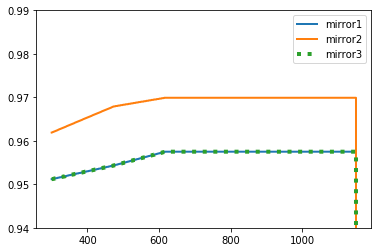

In [5]:
# check if mirror losses are the same ..
losses = {}
for m in ('mirror1', 'mirror2', 'mirror3'):
    losses[m] = Bandpass()
    losses[m].readThroughput(os.path.join(defaultDirs[m], '%s%s_Losses' % (m[0],m[-1]), 
                                          '%s%s_Losses.dat' % (m[0], m[-1])))
    linestyle = '-'
    width=2
    if m == 'mirror3':
        linestyle=':'
        width=4
    plt.plot(losses[m].wavelen, losses[m].sb, linestyle=linestyle, linewidth=width, label=m)
plt.ylim(0.94, 0.99)
plt.legend()

In [6]:
# Mirror losses are not the same (up vs. down-facing I think), so turn them off for now.
mirror = {}
mirror['Al'] = st.buildMirror(defaultDirs['mirror1'], addLosses=False)
mirror['Ag'] = st.buildMirror(defaultDirs['mirror2'], addLosses=False)
# BUT because they are not material dependent and just multiply by the mirror throughput .. 
# we can add them back anyway



In [7]:
# Ok .. 8 combos are actually 4 because it doesn't matter which order the mirrors are in.
combos = [['Al', 'Al', 'Al'], ['Al', 'Ag', 'Al'], ['Ag', 'Al', 'Ag'], ['Ag', 'Ag', 'Ag']]

m5 = {}
m5_badrd = {}
system_all = {}
for combo in combos:
    hardware = {}
    system = {}
    for f in filters:
        wavelen = detector.wavelen
        # Hardware
        sb = detector.sb * lens1.sb * lens2.sb * lens3.sb * filters[f].sb
        sb *= losses['mirror1'].sb * losses['mirror2'].sb * losses['mirror3'].sb
        sb *= mirror[combo[0]].sb * mirror[combo[1]].sb * mirror[combo[2]].sb
        hardware[f] = Bandpass()
        hardware[f].setBandpass(wavelen, sb)
        system[f] = Bandpass()
        system[f].setBandpass(wavelen, sb * atmos.sb)
    system_all['-'.join(combo)] = system
    m5['-'.join(combo)] = st.makeM5(hardware, system)
    m5_badrd['-'.join(combo)] = st.makeM5(hardware, system, exptime=30, nexp=1, readnoise=18, 
                                          othernoise=0, darkcurrent=0.2)

In [8]:
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='k', lw=4),
                Line2D([0], [0], color='k', lw=4),
                Line2D([0], [0], color='k', lw=4)]

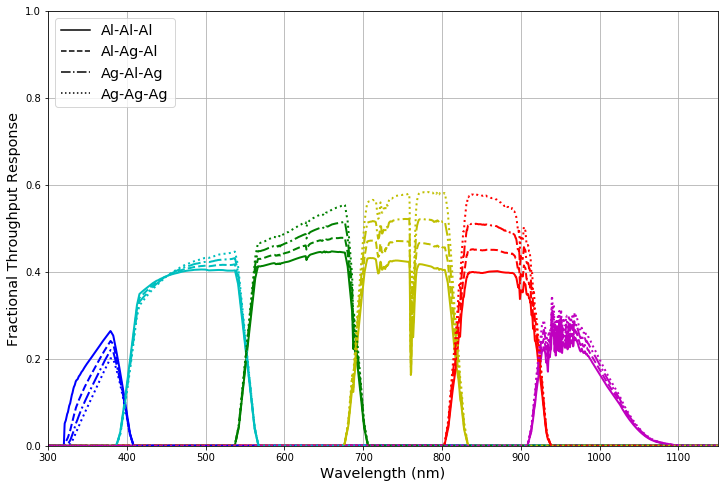

In [9]:
plt.figure(figsize=(12, 8))
linestyles = ['-', '--', '-.', ':']
leg_elements = []
for i, combo in enumerate(combos):
    label = '-'.join(combo)
    linestyle= linestyles[i]
    st.plotBandpasses(system_all['-'.join(combo)], newfig=False, addlegend=False, linestyle=linestyle)
    leg_elements.append(Line2D([0], [0], color='k', linestyle=linestyle, label=label))
plt.legend(handles=leg_elements, loc='upper left', fontsize='x-large', fancybox=True)

In [66]:
d = pd.DataFrame({'Al-Al-Al': m5['Al-Al-Al'].m5, 'Al-Ag-Al': m5['Al-Ag-Al'].m5,
                  'Ag-Al-Ag': m5['Ag-Al-Ag'].m5, 'Ag-Ag-Ag': m5['Ag-Ag-Ag'].m5})
d_badrd = pd.DataFrame({'Al-Al-Al': m5_badrd['Al-Al-Al'].m5, 'Al-Ag-Al': m5_badrd['Al-Ag-Al'].m5,
                  'Ag-Al-Ag': m5_badrd['Ag-Al-Ag'].m5, 'Ag-Ag-Ag': m5_badrd['Ag-Ag-Ag'].m5})
d

,Al-Al-Al,Al-Ag-Al,Ag-Al-Ag,Ag-Ag-Ag
u,23.947619,23.764100,23.604988,23.459721
g,24.802889,24.806430,24.810317,24.814542
r,24.317151,24.351669,24.386050,24.420302
i,23.857319,23.919008,23.980110,24.040674
z,23.271318,23.339608,23.407454,23.474897
y,22.406266,22.446767,22.487143,22.527402


In [72]:
delta_m5 = (d.T - d['Al-Ag-Al'].T)
delta_m5_badrd = d_badrd.T - d['Al-Ag-Al'].T
delta_m5 = delta_m5.T.join(delta_m5_badrd.T, rsuffix='_bdRd')
delta_m5
# Positive values mean deeper limiting magnitudes

,Al-Al-Al,Al-Ag-Al,Ag-Al-Ag,Ag-Ag-Ag,Al-Al-Al_bdRd,Al-Ag-Al_bdRd,Ag-Al-Ag_bdRd,Ag-Ag-Ag_bdRd
u,0.183519,0.0,-0.159112,-0.304379,-0.085461,-0.293007,-0.466785,-0.622343
g,-0.003542,0.0,0.003887,0.008112,-0.144867,-0.140320,-0.135392,-0.130089
r,-0.034518,0.0,0.034381,0.068634,-0.124355,-0.086121,-0.048123,-0.010357
i,-0.061690,0.0,0.061102,0.121666,-0.133064,-0.065416,0.001253,0.067002
z,-0.068290,0.0,0.067846,0.135289,-0.119286,-0.046448,0.025601,0.096917
y,-0.040502,0.0,0.040376,0.080635,-0.078781,-0.036020,0.006498,0.048785


In [77]:
# Effective time calculation
# Fractional change in effective time is proportional to change in m5.
dtime = np.power(10, -0.8 * (delta_m5))
dtime

,Al-Al-Al,Al-Ag-Al,Ag-Al-Ag,Ag-Ag-Ag,Al-Al-Al_bdRd,Al-Ag-Al_bdRd,Ag-Al-Ag_bdRd,Ag-Ag-Ag_bdRd
u,0.713156,1.0,1.340570,1.751874,1.170493,1.715560,2.362804,3.146838
g,1.006545,1.0,0.992866,0.985169,1.305851,1.294960,1.283256,1.270781
r,1.065649,1.0,0.938631,0.881238,1.257431,1.171916,1.092694,1.019262
i,1.120345,1.0,0.893550,0.799222,1.277765,1.128061,0.997694,0.883890
z,1.134050,1.0,0.882517,0.779415,1.245744,1.089327,0.953936,0.836501
y,1.077460,1.0,0.928323,0.861969,1.156177,1.068601,0.988102,0.914054


In [78]:
SRD_time_distribution = pd.Series({'u': 0.068, 'g': 0.097, 'r': 0.223, 'i': 0.223, 'z': 0.194, 'y': 0.194})
SRD_time_distribution 

u    0.068
g    0.097
r    0.223
i    0.223
z    0.194
y    0.194
dtype: float64

In [79]:
weighted_dtime = dtime.multiply(SRD_time_distribution, axis=0)
weighted_dtime

,Al-Al-Al,Al-Ag-Al,Ag-Al-Ag,Ag-Ag-Ag,Al-Al-Al_bdRd,Al-Ag-Al_bdRd,Ag-Al-Ag_bdRd,Ag-Ag-Ag_bdRd
u,0.048495,0.068,0.091159,0.119127,0.079594,0.116658,0.160671,0.213985
g,0.097635,0.097,0.096308,0.095561,0.126668,0.125611,0.124476,0.123266
r,0.237640,0.223,0.209315,0.196516,0.280407,0.261337,0.243671,0.227295
i,0.249837,0.223,0.199262,0.178226,0.284942,0.251558,0.222486,0.197108
z,0.220006,0.194,0.171208,0.151207,0.241674,0.211329,0.185064,0.162281
y,0.209027,0.194,0.180095,0.167222,0.224298,0.207309,0.191692,0.177327


In [80]:
weighted_dtime.sum()

Al-Al-Al         1.062639
Al-Ag-Al         0.999000
Ag-Al-Ag         0.947346
Ag-Ag-Ag         0.907860
Al-Al-Al_bdRd    1.237583
Al-Ag-Al_bdRd    1.173802
Ag-Al-Ag_bdRd    1.128059
Ag-Ag-Ag_bdRd    1.101261
dtype: float64

In [81]:
np.round((weighted_dtime.sum() * 10 * 365.25 - 3652.5) * 800)

Al-Al-Al         183031.0
Al-Ag-Al          -2922.0
Ag-Al-Ag        -153855.0
Ag-Ag-Ag        -269234.0
Al-Al-Al_bdRd    694217.0
Al-Ag-Al_bdRd    507850.0
Ag-Al-Ag_bdRd    374187.0
Ag-Ag-Ag_bdRd    295886.0
dtype: float64